In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import measureOC

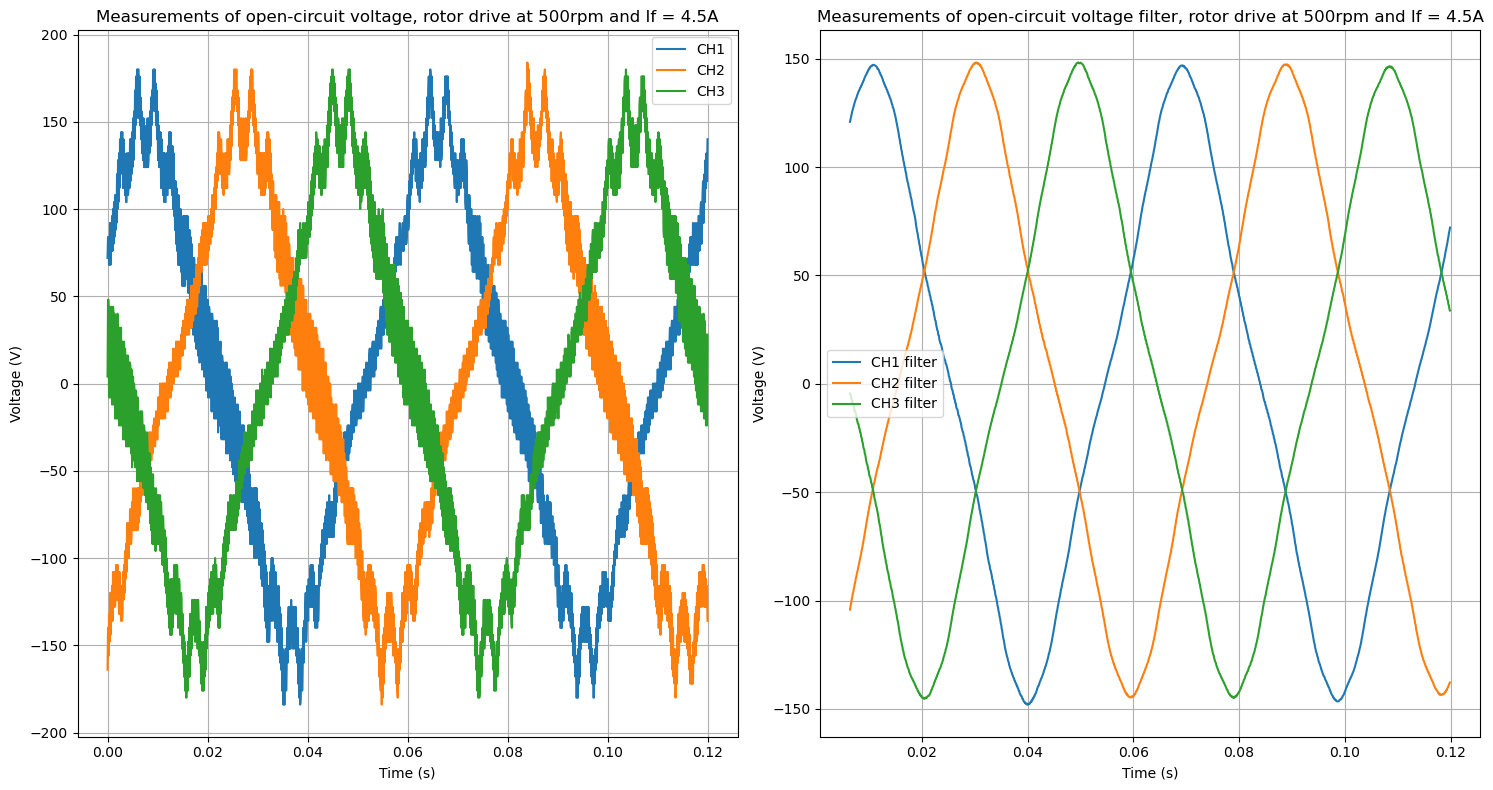

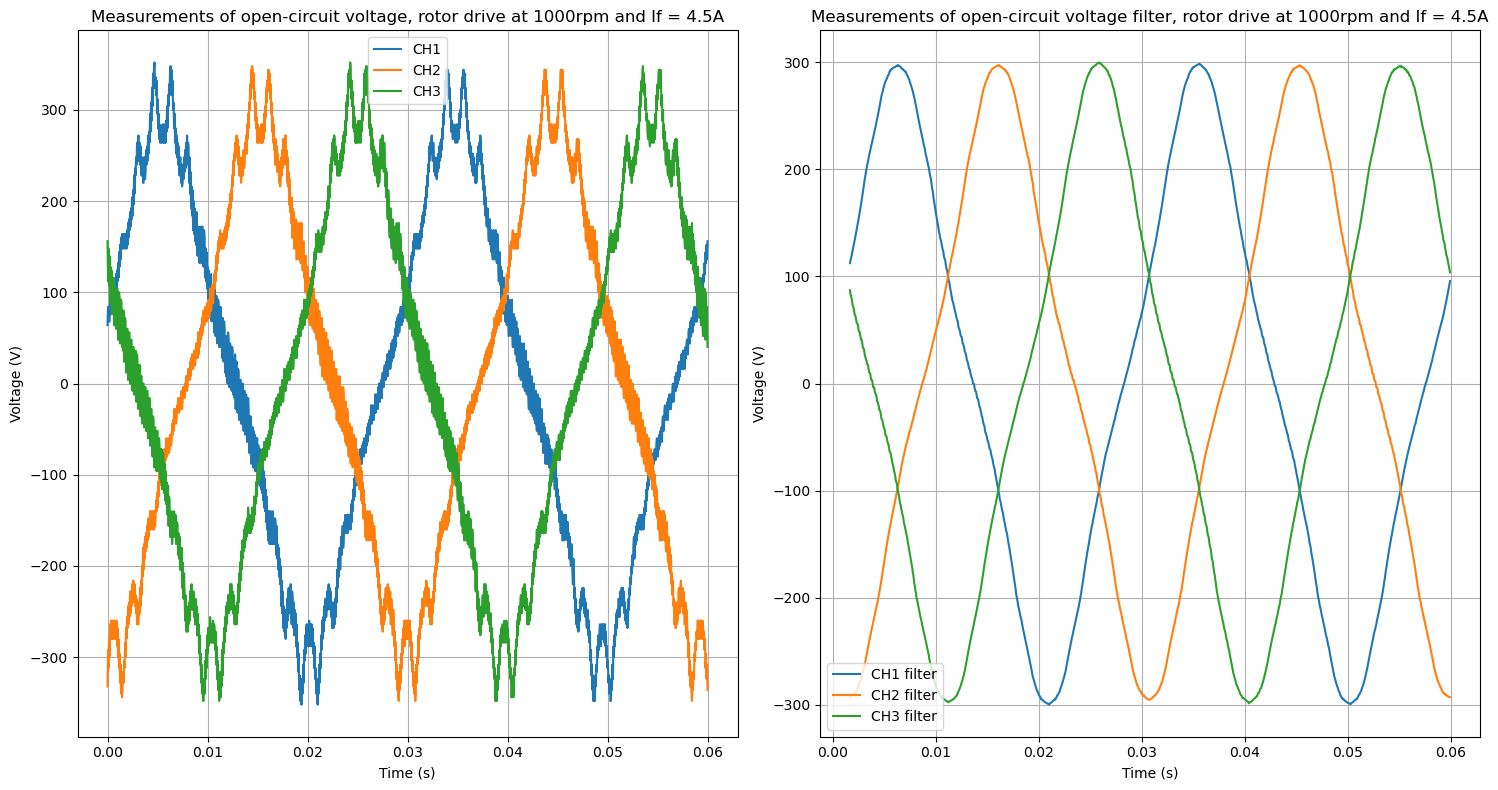

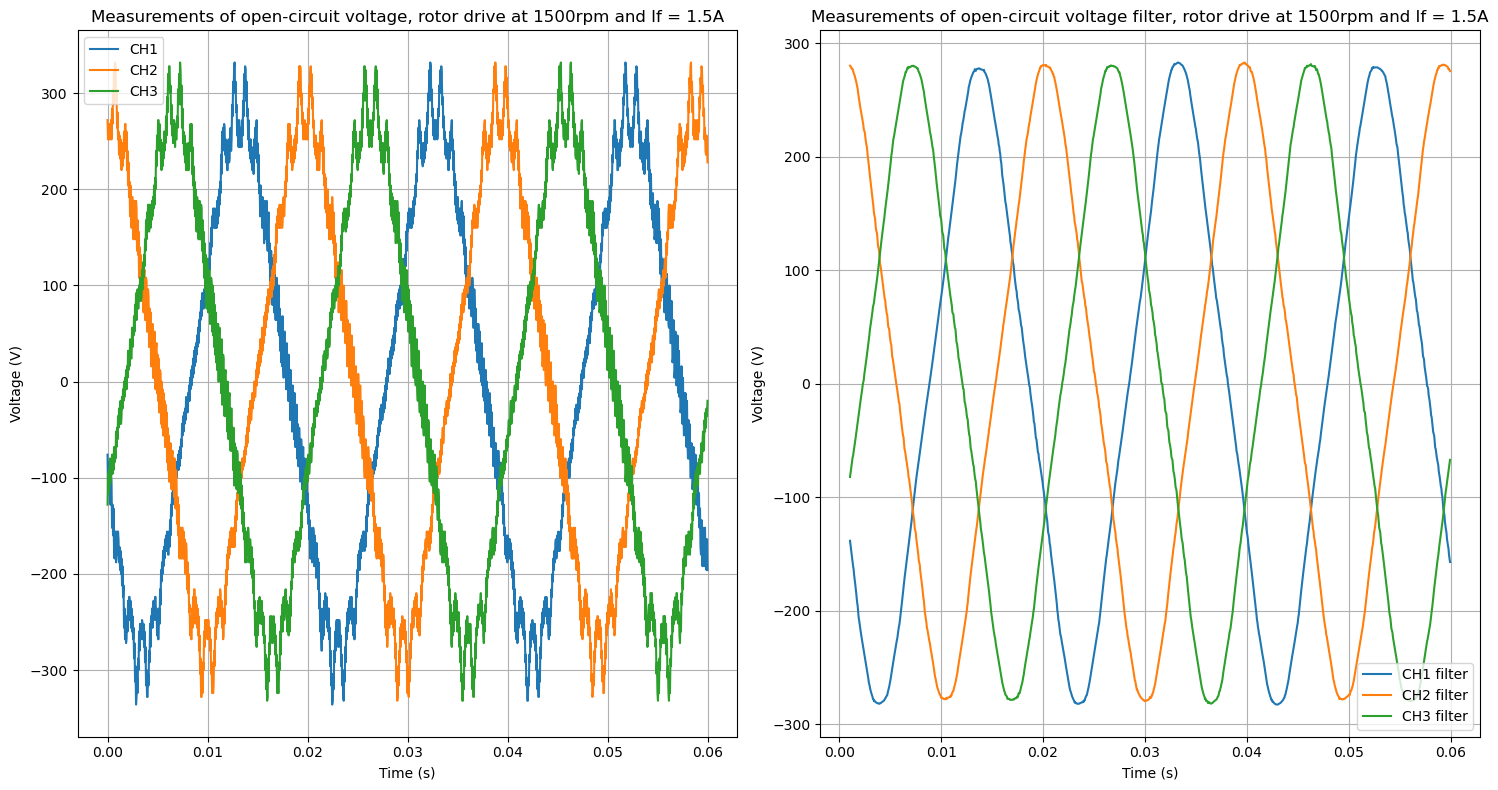

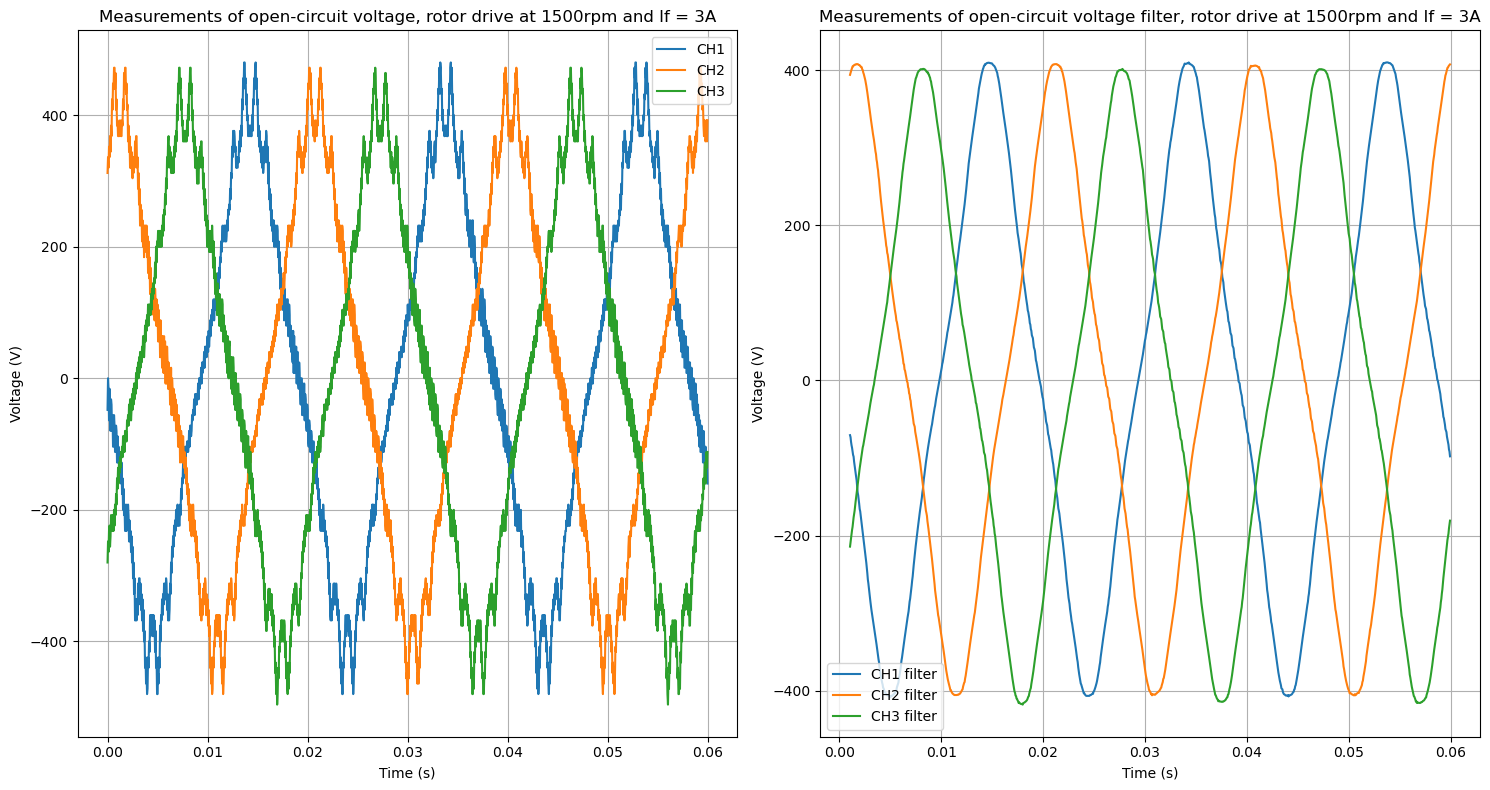

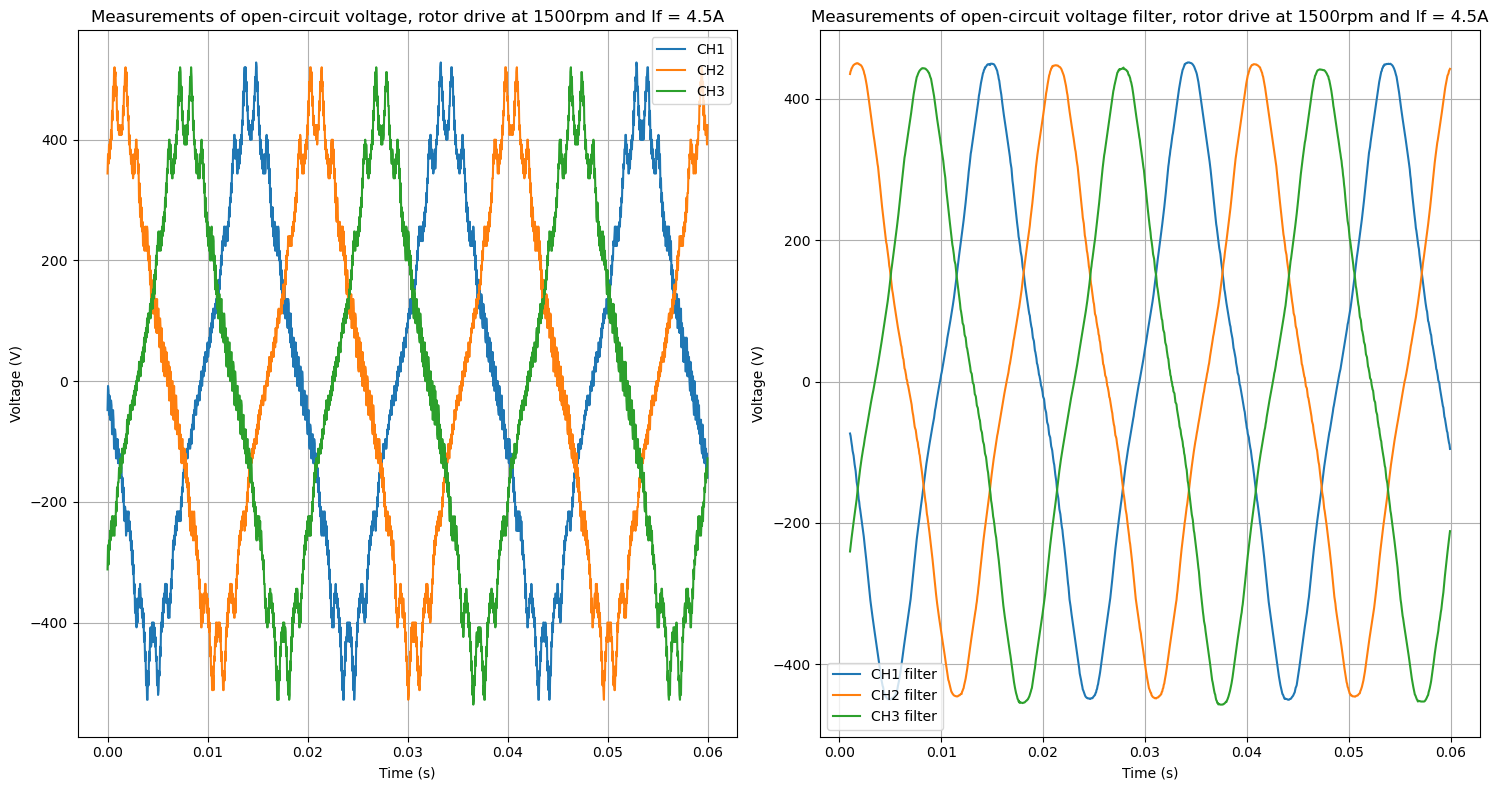

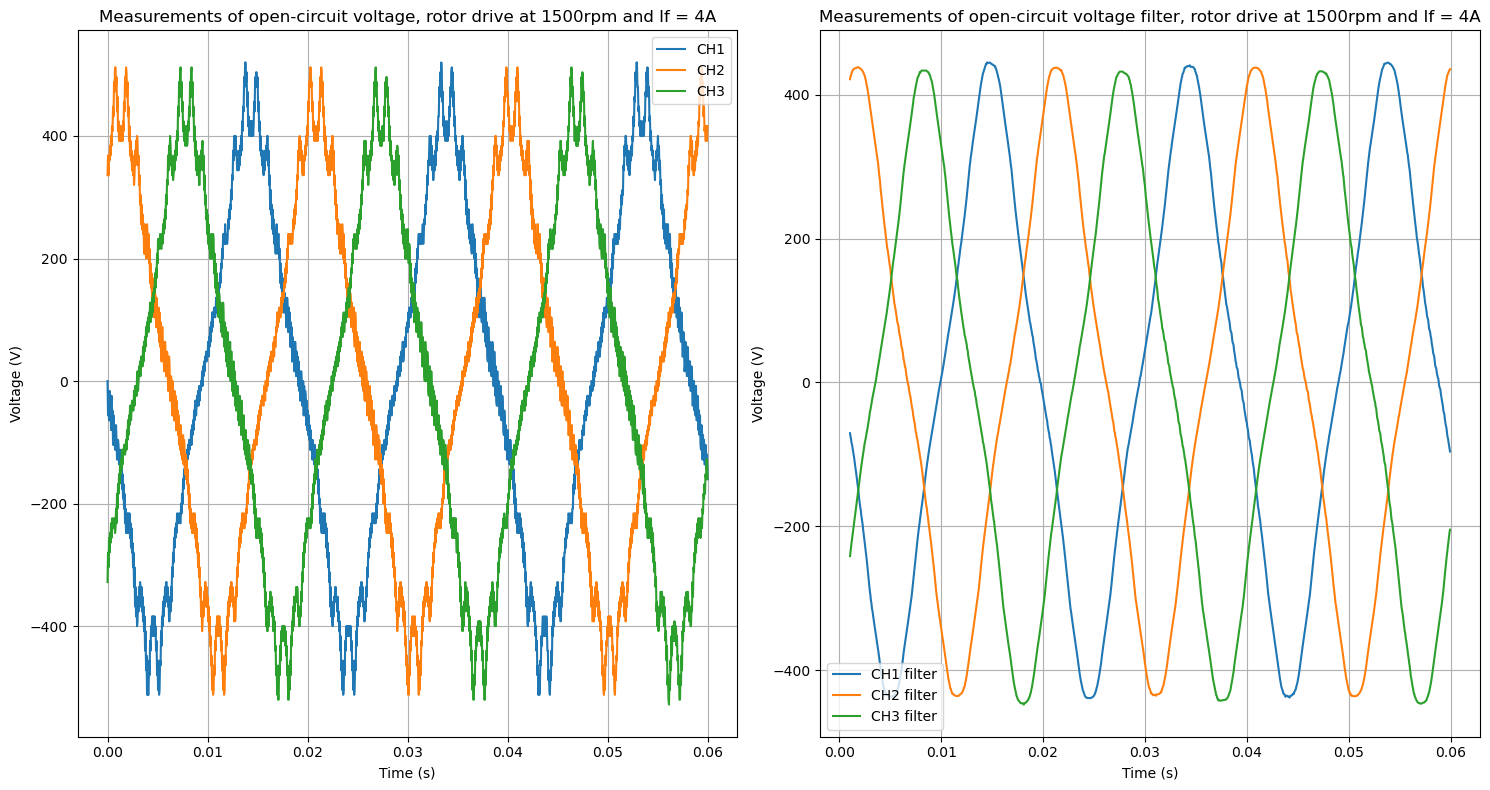

In [2]:
#create a pandas dataframe with RPM, If, v1, v2, v3
df = pd.DataFrame(columns=['RPM', 'If', 'v1', 'v2', 'v3'])

#add data to the dataframe
v1, v2, v3 = measureOC.computeOC("Data/pn_4_5A_500.csv", 500, 4.5, 65)
df = pd.concat([df,pd.DataFrame({'RPM': 500, 'If': 4.5, 'v1': v1, 'v2': v2, 'v3': v3}, index=[0])], ignore_index=True)

v1, v2, v3 = measureOC.computeOC("Data/pn_4_5A_1000.csv", 1000, 4.5, 34)
df = pd.concat([df,pd.DataFrame({'RPM': 1000, 'If': 4.5, 'v1': v1, 'v2': v2, 'v3': v3}, index=[0])], ignore_index=True)

v1, v2, v3 = measureOC.computeOC("Data/pn_1_5A_1500.csv", 1500, 1.5, 22)
df = pd.concat([df,pd.DataFrame({'RPM': 1500, 'If': 1.5, 'v1': v1, 'v2': v2, 'v3': v3}, index=[0])], ignore_index=True)

v1, v2, v3 = measureOC.computeOC("Data/pn_3A_1500.csv", 1500, 3, 22)
df = pd.concat([df,pd.DataFrame({'RPM': 1500, 'If': 3, 'v1': v1, 'v2': v2, 'v3': v3}, index=[0])], ignore_index=True)

v1, v2, v3 = measureOC.computeOC("Data/pn_4_5A_1500.csv", 1500, 4.5, 22)
df = pd.concat([df,pd.DataFrame({'RPM': 1500, 'If': 4.5, 'v1': v1, 'v2': v2, 'v3': v3}, index=[0])], ignore_index=True)

v1, v2, v3 = measureOC.computeOC("Data/pn_4A_1500.csv", 1500, 4, 22)
df = pd.concat([df,pd.DataFrame({'RPM': 1500, 'If': 4, 'v1': v1, 'v2': v2, 'v3': v3}, index=[0])], ignore_index=True)



,RPM,If,v1,v2,v3,vmean
0,500,4.5,104.042604,104.782346,104.825861,104.550270
1,1000,4.5,210.967388,210.218687,211.882467,211.022847
2,1500,1.5,200.046937,200.175502,199.146983,199.789807
3,1500,3.0,289.785215,288.242437,283.871231,287.299628
4,1500,4.5,319.355135,318.583746,314.212541,317.383807
5,1500,4.0,314.726800,310.098465,306.755778,310.527014


Text(0.5, 1.0, 'vmean vs If for RPM=1500')

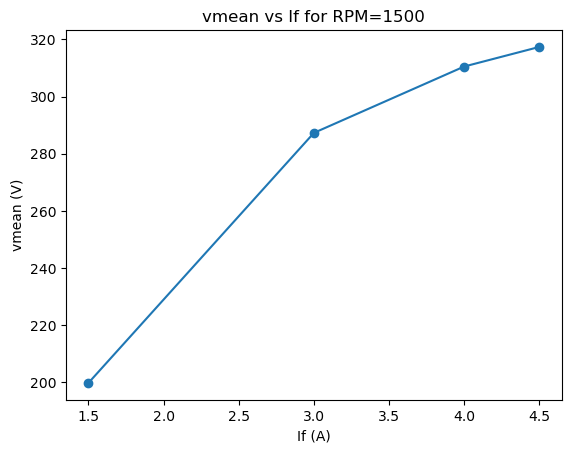

In [3]:
#compute vmean of each row of df
df['vmean'] = df[['v1', 'v2', 'v3']].mean(axis=1)

display(df)

#plot vmean vs If for RPM=1500
df_1500 = df[df['RPM'] == 1500]
#rank from smallest to largest If
df_1500 = df_1500.sort_values(by=['If'])
plt.plot(df_1500['If'], df_1500['vmean'], '-o')
plt.xlabel('If (A)')
plt.ylabel('vmean (V)')
plt.title('vmean vs If for RPM=1500')


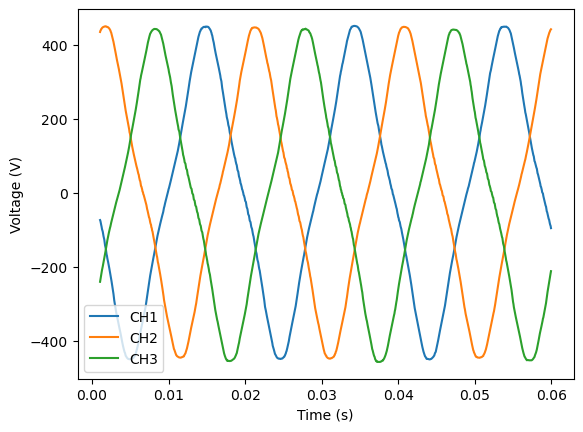

In [4]:
measurements = pd.read_csv("Data/pn_4_5A_1500.csv")

#compute time column
increment = measurements['Increment'][0]
time = np.linspace(0, increment*(len(measurements)-2), len(measurements)-1)

#remove line 0 of measurements_1
measurements = measurements.drop(0)
#remove coloum X, Start, Increment and Unnamed: 5
measurements = measurements.drop(columns=['X', 'Start', 'Increment', 'Unnamed: 6'])

#add time column
measurements['Time'] = time

#transform column CH1, CH2 and CH3 to float
measurements['CH1'] = measurements['CH1'].astype(float)
measurements['CH2'] = measurements['CH2'].astype(float) 
measurements['CH3'] = measurements['CH3'].astype(float)

measurements['CH1'] = measurements['CH1'].rolling(window=22).mean()
measurements['CH2'] = measurements['CH2'].rolling(window=22).mean()
measurements['CH3'] = measurements['CH3'].rolling(window=22).mean()

#plot CH1, CH2 and CH3 vs time
plt.figure()
plt.plot(measurements['Time'], measurements['CH1'], label='CH1')
plt.plot(measurements['Time'], measurements['CH2'], label='CH2')
plt.plot(measurements['Time'], measurements['CH3'], label='CH3')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()


In [5]:
# Clarke Transform: ABC to Alpha-Beta-0
def abc_to_alphaBeta0(a, b, c):
  alpha = (2/3)*(a - b/2 - c/2)
  beta  = (2/3)*(np.sqrt(3)*(b-c)/2)
  z     = (2/3)*((a+b+c)/2)
  return alpha, beta, z

# Park Transform: abc to dq0
def abc_to_dq0(a, b, c, wt, delta):
  d = (2/3)*(a*np.sin(wt+delta) + b*np.sin(wt+delta-(2*np.pi/3)) + c*np.sin(wt+delta+(2*np.pi/3)))
  q = (2/3)*(a*np.cos(wt+delta) + b*np.cos(wt+delta-(2*np.pi/3)) + c*np.cos(wt+delta+(2*np.pi/3)))
  z = (2/3)*(a+b+c)/2
  return d, q, z

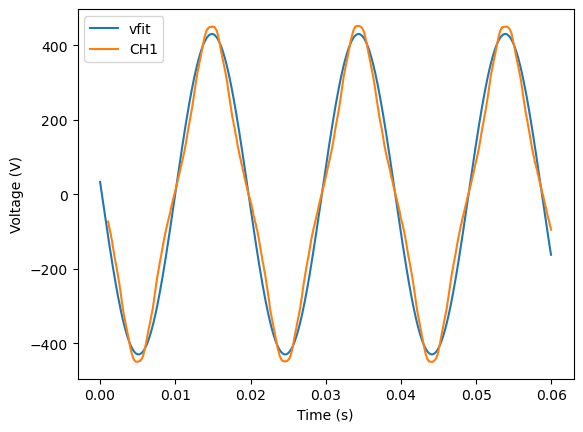

In [26]:
wt = 50*2*math.pi + 8
delta = 2*math.pi/3 - 0.6

#we need to find wt and delta 
measurements['vfit'] = measurements.apply(lambda row: 430*math.cos(wt*row['Time']+delta), axis=1)

#plot vfit and CH1 vs time
plt.figure()
plt.plot(measurements['Time'], measurements['vfit'], label='vfit')
plt.plot(measurements['Time'], measurements['CH1'], label='CH1')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()


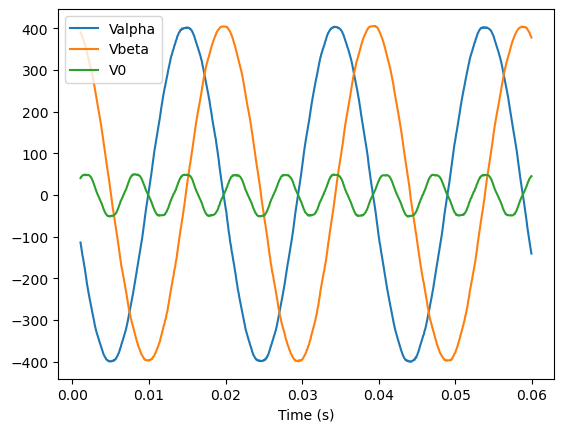

In [20]:
#CH1, 2 and 3 to alpha beta
measurements[['Valpha', 'Vbeta', 'V0']] = measurements.apply(lambda row: abc_to_alphaBeta0(row['CH1'], row['CH2'], row['CH3']), axis=1,result_type='expand')

#plot Valpha and Vbeta vs time
plt.figure()
plt.plot(measurements['Time'], measurements['Valpha'], label='Valpha')
plt.plot(measurements['Time'], measurements['Vbeta'], label='Vbeta')
plt.plot(measurements['Time'], measurements['V0'], label='V0')
plt.xlabel('Time (s)')
plt.legend()

401.8005246050485
2.995986532957943


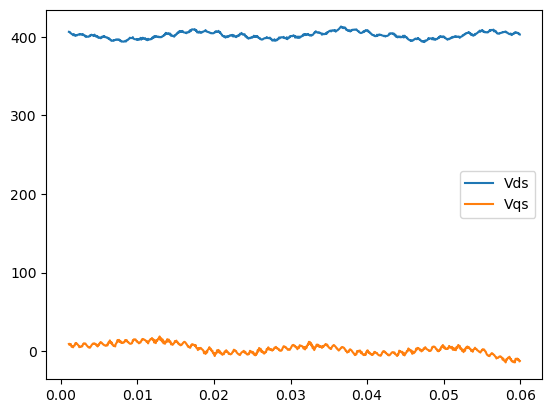

In [28]:
measurements['Vds'] = measurements.apply(lambda row: row['Valpha']*math.cos(wt*row['Time']+delta) + row['Vbeta']*math.sin(wt*row['Time']+delta), axis=1, result_type='expand')
measurements['Vqs'] = measurements.apply(lambda row: -row['Valpha']*math.sin(wt*row['Time']+delta) + row['Vbeta']*math.cos(wt*row['Time']+delta), axis=1, result_type='expand')

plt.figure()
plot = plt.plot(measurements['Time'], measurements['Vds'], label='Vds')
plot = plt.plot(measurements['Time'], measurements['Vqs'], label='Vqs')
plt.legend()

#print mean of Vds and Vqs
print(measurements['Vds'].mean())
print(measurements['Vqs'].mean())